### Import Library

In [1]:
# Base Library
import pandas as pd
import numpy as np

# Library untuk Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk Data Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Library untuk Modeling dengan XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

# Library untuk Evaluasi Model
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error

### Business Understanding
---

1.	Algoritma machine learning apa yang dapat digunakan untuk memprediksi harga rumah di Kabupaten Tangerang?
2.	Bagaimana cara mengukur keakuratan dari model prediksi harga rumah di Kabupaten Tangerang?


### Data Understanding

In [2]:
# Baca Data
df = pd.read_csv("../Dataset/hasil_scraping_rumah123.csv", engine='pyarrow', sep=';')
df = df.drop(columns=['IMB', 'Lainnya', 'Garasi'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   4991 non-null   object
 1   Harga                 4991 non-null   object
 2   Lokasi                4991 non-null   object
 3   Kamar Tidur           4991 non-null   int64 
 4   Kamar Mandi           4991 non-null   int64 
 5   Luas Tanah            4991 non-null   object
 6   Luas Bangunan         4991 non-null   object
 7   Sertifikat            4991 non-null   object
 8   Daya Listrik          4991 non-null   object
 9   Jumlah Lantai         4991 non-null   int64 
 10  Kondisi Properti      4991 non-null   object
 11  Carport               4991 non-null   int64 
 12  Kamar Tidur Pembantu  4991 non-null   int64 
 13  Kamar Mandi Pembantu  4991 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 546.0+ KB


In [3]:
# Lihat 5 baris data pertama
df.head()

,URL,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,https://www.rumah123.com/properti/tangerang/ho...,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


In [4]:
# Fungsi untuk mengkonversi harga dengan koma sebagai desimal
def convert_price(price):
    # Hapus 'Rp' dan spasi
    price = price.replace('Rp', '').strip()
    
    # Pisahkan angka dan satuan
    if 'Juta' in price:
        value = price.replace(' Juta', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e6  # 1 Juta = 1.000.000
    elif 'Miliar' in price:
        value = price.replace(' Miliar', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e9  # 1 Miliar = 1.000.000.000
    else:
        return None  # Jika format tidak sesuai
    
    # Konversi ke float dengan titik desimal, lalu ke integer
    value = float(value)  
    return int(value * multiplier)

# Menkonversi kolom 'Harga'
df['Harga'] = df['Harga'].apply(convert_price)

# Lihat 5 baris pertama setelah kolom 'Harga' dikonversi
df.head()

,URL,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,https://www.rumah123.com/properti/tangerang/ho...,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


In [5]:
# # Cek lokasi
# # Cek apakah kolom "Lokasi" ada di dataset
# if "Lokasi" in df.columns:
#     # Hitung jumlah kemunculan tiap lokasi
#     lokasi_counts = df["Lokasi"].value_counts()
    
#     # Simpan hasilnya ke file teks
#     file_path = "lokasi_counts.txt"
#     lokasi_counts.to_csv(file_path, sep="\t", header=True)

#     print(f"Hasil disimpan di: {file_path}")
# else:
#     print("Kolom 'Lokasi' tidak ditemukan dalam dataset.")

In [6]:
# Mapping lokasi
# Daftar kecamatan di Kabupaten Tangerang
desa_kabupaten = {
    "BSD Eminent": "Pagedangan",
    "BSD Green Wich": "Pagedangan",
    "BSD Avani": "Pagedangan",
    "BSD Vanya Park": "Pagedangan",
    "BSD Foresta": "Pagedangan",
    "BSD The Green": "Pagedangan",
    "BSD Kencana Loka": "Pagedangan",
    "BSD Taman Giri Loka": "Pagedangan",
    "BSD Telaga Golf": "Pagedangan",
    "BSD Neo Catalonia": "Pagedangan",
    "BSD Provance Parkland": "Pagedangan",
    "BSD Alegria": "Pagedangan",
    "Cikupa": "Cikupa",
    "Cikupa Citra Raya": "Cikupa",
    "Cisauk" : "Cisauk",
    "Suvarna Sutera": "Cikupa",
    "Panongan": "Panongan",
    "Curug": "Curug",
    "Legok": "Legok",
    "Pasar Kemis": "Pasar Kemis",
    "Sepatan": "Sepatan",
    "Bitung": "Curug",
    "Tigaraksa": "Tigaraksa",
    "Balaraja": "Balaraja",
    "Jayanti": "Jayanti",
    "Kosambi": "Kosambi",
    "Teluk Naga": "Teluk Naga",
    "Mauk": "Mauk",
    "Kresek": "Kresek",
    "Solear": "Solear",
    "Sindang Jaya": "Sindang Jaya",
    "Rajeg": "Rajeg",
    "Kadu": "Kadu",
    "Jatake": "Jatiuwung",
    "Bojong Nangka": "Kelapa Dua",
    "Suradita": "Cisauk",
    "Cukang Galih": "Curug",
    "Gading Serpong": "Kelapa Dua",
    "Gading Serpong Pondok Hijau Golf": "Kelapa Dua",
    "Gading Serpong The Spring": "Kelapa Dua",
    "Gading Serpong Scientia Garden": "Kelapa Dua",
    "Gading Serpong Samara Village": "Kelapa Dua",
    "Gading Serpong IL Lago": "Kelapa Dua",
    "Gading Serpong Elista Village": "Kelapa Dua",
    "Gading Serpong Serenade Lake": "Kelapa Dua",
    "Gading Serpong Cluster Bohemia": "Kelapa Dua",
    "Gading Serpong Omaha Village": "Kelapa Dua",
    "Gading Serpong La Bella Village": "Kelapa Dua",
    "Gading Serpong Virginia Village": "Kelapa Dua",
    "Gading Serpong Cluster Oleaster": "Kelapa Dua",
    "Gading Serpong Cluster Michelia": "Kelapa Dua",
    "Gading Serpong Karelia Village": "Kelapa Dua",
    "Gading Serpong Andalucia": "Kelapa Dua",
    "Gading Serpong Cluster IL Rosa": "Kelapa Dua",
    "Pasar Kemis" : "Pasar Kemis", 
}

# Fungsi untuk mengekstrak kecamatan dari lokasi
def extract_kecamatan(lokasi):
    for key in desa_kabupaten.keys():
        if key in lokasi:
            return desa_kabupaten[key]
    return None  # Jika tidak ditemukan

# Filter hanya rumah di Kabupaten Tangerang
df["Kecamatan"] = df["Lokasi"].apply(extract_kecamatan)
df_kabupaten = df.dropna(subset=["Kecamatan"])  # Hapus yang bukan Kabupaten Tangerang
df_kabupaten = df_kabupaten.drop(columns=['URL', 'Lokasi'])

# Merapikan data
# Hapus baris dengan nilai None, 'Lainnya', atau 'Lainnya Watt'
df_kabupaten = df_kabupaten[~df_kabupaten['Daya Listrik'].isin([None, 'Lainnya', 'Lainnya Watt'])]

# Pastikan semua kolom bertipe string sebelum menggunakan .str.replace()
df_kabupaten['Daya Listrik'] = df_kabupaten['Daya Listrik'].astype(str).str.replace(' Watt', '', regex=False).astype('Int64')
df_kabupaten['Luas Tanah'] = df_kabupaten['Luas Tanah'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')
df_kabupaten['Luas Bangunan'] = df_kabupaten['Luas Bangunan'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')

# Konversi kolom angka langsung ke integer (mendukung NaN)
df_kabupaten['Kamar Tidur'] = df_kabupaten['Kamar Tidur'].astype('Int64')
df_kabupaten['Kamar Mandi'] = df_kabupaten['Kamar Mandi'].astype('Int64')
df_kabupaten['Jumlah Lantai'] = df_kabupaten['Jumlah Lantai'].astype('Int64')
df_kabupaten['Carport'] = df_kabupaten['Carport'].astype('Int64')
df_kabupaten['Kamar Tidur Pembantu'] = df_kabupaten['Kamar Tidur Pembantu'].astype('Int64')
df_kabupaten['Kamar Mandi Pembantu'] = df_kabupaten['Kamar Mandi Pembantu'].astype('Int64')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Sudah Renovasi', 'Bagus')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Renovasi Total', 'Butuh Renovasi')
df_kabupaten['Kondisi Properti'] = df_kabupaten['Kondisi Properti'].str.replace('Renovasi Minimum', 'Butuh Renovasi')

# Filter data yang diperlukan
df_kabupaten = df_kabupaten[(df_kabupaten['Carport'] != 0) & (df_kabupaten['Carport'] != 6)]
df_kabupaten = df_kabupaten[(df_kabupaten['Jumlah Lantai'] != 0) & (df_kabupaten['Jumlah Lantai'] != 4)]
df_kabupaten = df_kabupaten[(df_kabupaten['Sertifikat'] != "Strata") & (df_kabupaten['Sertifikat'] != 'Hak Sewa')]

# Lihat informasi dataset setelah mapping dan filter data
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1802 entries, 6 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 1802 non-null   int64 
 1   Kamar Tidur           1802 non-null   Int64 
 2   Kamar Mandi           1802 non-null   Int64 
 3   Luas Tanah            1802 non-null   Int64 
 4   Luas Bangunan         1802 non-null   Int64 
 5   Sertifikat            1802 non-null   object
 6   Daya Listrik          1802 non-null   Int64 
 7   Jumlah Lantai         1802 non-null   Int64 
 8   Kondisi Properti      1802 non-null   object
 9   Carport               1802 non-null   Int64 
 10  Kamar Tidur Pembantu  1802 non-null   Int64 
 11  Kamar Mandi Pembantu  1802 non-null   Int64 
 12  Kecamatan             1802 non-null   object
dtypes: Int64(9), int64(1), object(3)
memory usage: 212.9+ KB


In [7]:
# Lihat 5 data teratas pada dataset setelah mapping dan filter data
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu,Kecamatan
6,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
8,1000000000,2,1,90,55,SHM,2200,1,Bagus,1,0,0,Kelapa Dua
14,1000000000,3,2,644,135,SHM,1300,1,Bagus,1,0,0,Balaraja
15,1000000000,3,2,66,79,SHM,3500,2,Bagus,1,0,0,Pasar Kemis
21,1000000000,3,3,120,166,SHM,1300,2,Baru,2,1,0,Cikupa


#### Exploratory Data Analysis

In [8]:
# Lihat statistik dari dataset
df_kabupaten.describe()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Daya Listrik,Jumlah Lantai,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
count,1.802000e+03,1802.0,1802.0,1802.0,1802.0,1802.0,1802.0,1802.0,1802.0,1802.0
mean,3.040816e+09,3.259156,2.596004,139.508879,156.251942,3476.942286,1.869034,1.302442,0.574917,0.50444
std,3.114307e+09,0.97554,1.013482,99.378318,133.54565,2405.245338,0.516841,0.533273,0.583117,0.523975
min,1.480000e+08,1.0,1.0,30.0,16.0,450.0,1.0,1.0,0.0,0.0
25%,1.330000e+09,3.0,2.0,78.0,78.0,2200.0,2.0,1.0,0.0,0.0
50%,2.200000e+09,3.0,3.0,119.0,125.0,2200.0,2.0,1.0,1.0,0.0
75%,3.600000e+09,4.0,3.0,162.0,188.0,4400.0,2.0,2.0,1.0,1.0
max,3.500000e+10,9.0,9.0,1441.0,2021.0,33000.0,3.0,4.0,4.0,2.0


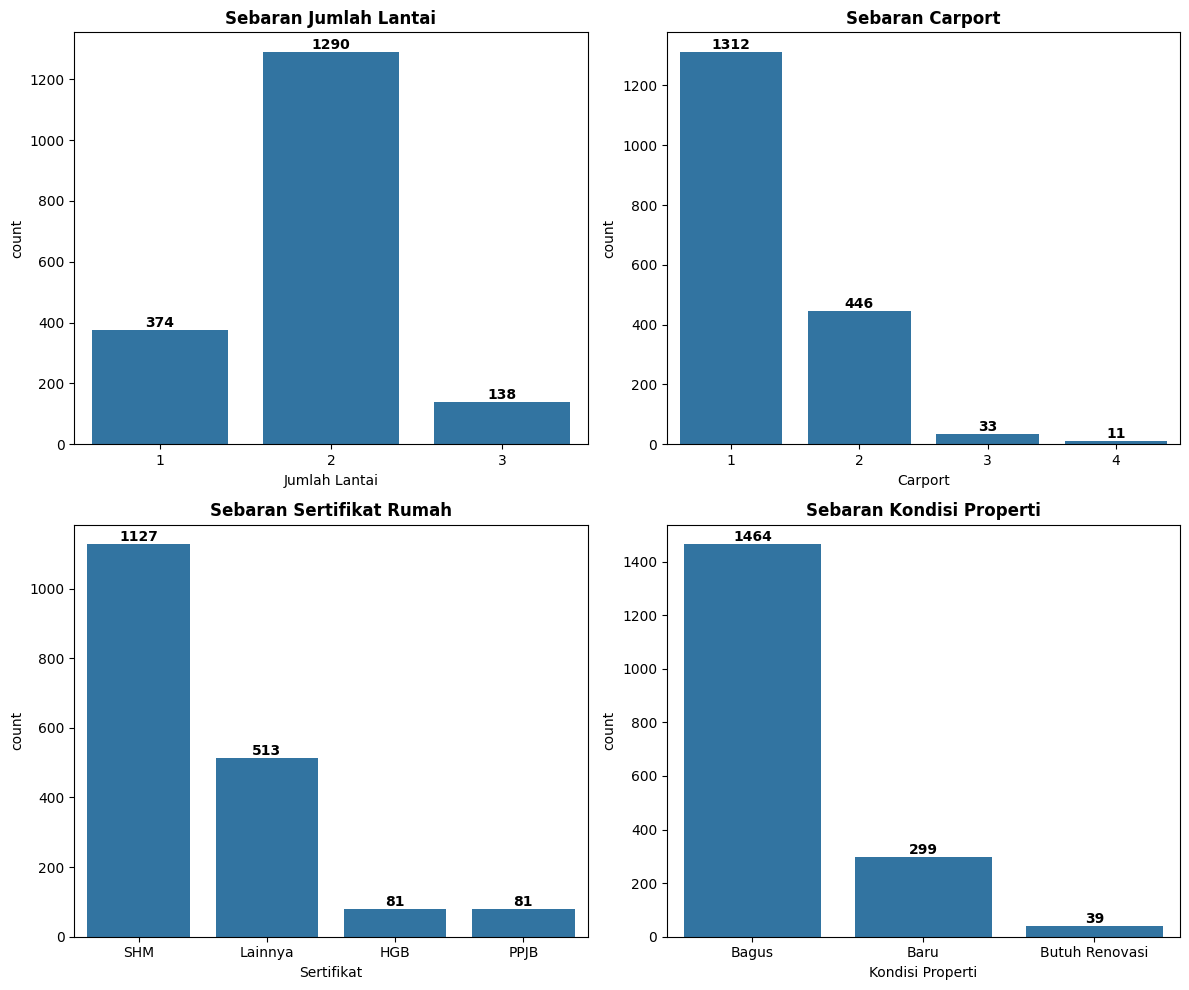

In [9]:
# Visualisasi beberapa kolom
# Membuat figure dengan 2 baris, 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List kolom dan judul
columns = ['Jumlah Lantai', 'Carport', 'Sertifikat', 'Kondisi Properti']
titles = ['Sebaran Jumlah Lantai', 'Sebaran Carport', 'Sebaran Sertifikat Rumah', 'Sebaran Kondisi Properti']

# Loop untuk membuat countplot dan menambahkan data label
for i, ax in enumerate(axes.flat):
    sns.countplot(x=df_kabupaten[columns[i]], ax=ax)
    ax.set_title(titles[i], weight='bold')

    # Menambahkan label di atas batang
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()


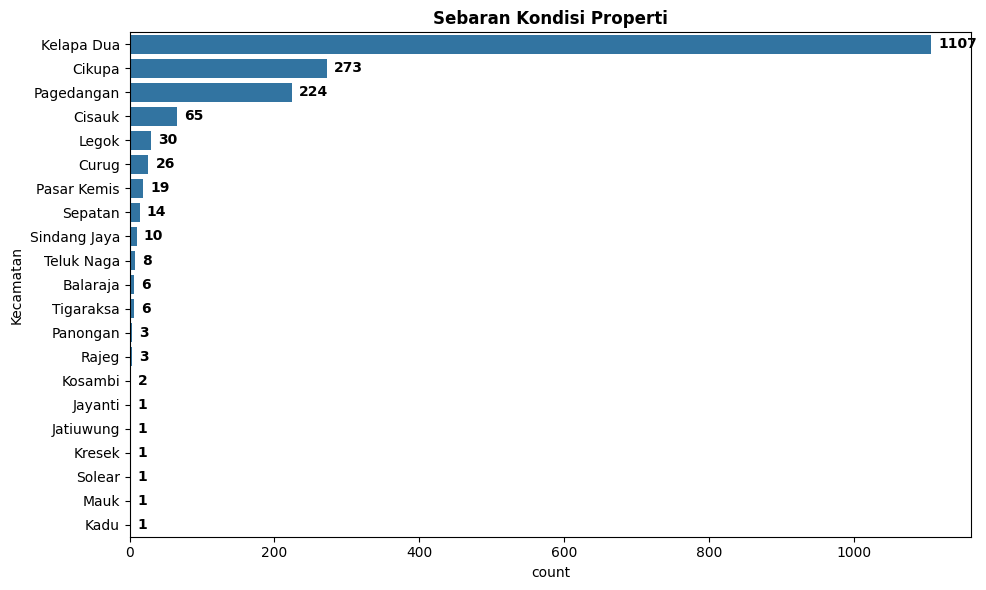

In [10]:
# Lihat sebaran kecamatan
# Membuat figure
plt.figure(figsize=(10, 6))

# Membuat countplot dengan urutan berdasarkan jumlah data
ax = sns.countplot(y=df_kabupaten['Kecamatan'], order=df_kabupaten['Kecamatan'].value_counts().index)

# Menambahkan judul
plt.title("Sebaran Kondisi Properti", weight='bold')

# Menambahkan label pada setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',  # Nilai jumlah properti
                (p.get_width(), p.get_y() + p.get_height() / 2),  # Posisi teks
                ha='left', va='center', fontsize=10, fontweight='bold', xytext=(5, 0), textcoords='offset points')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()

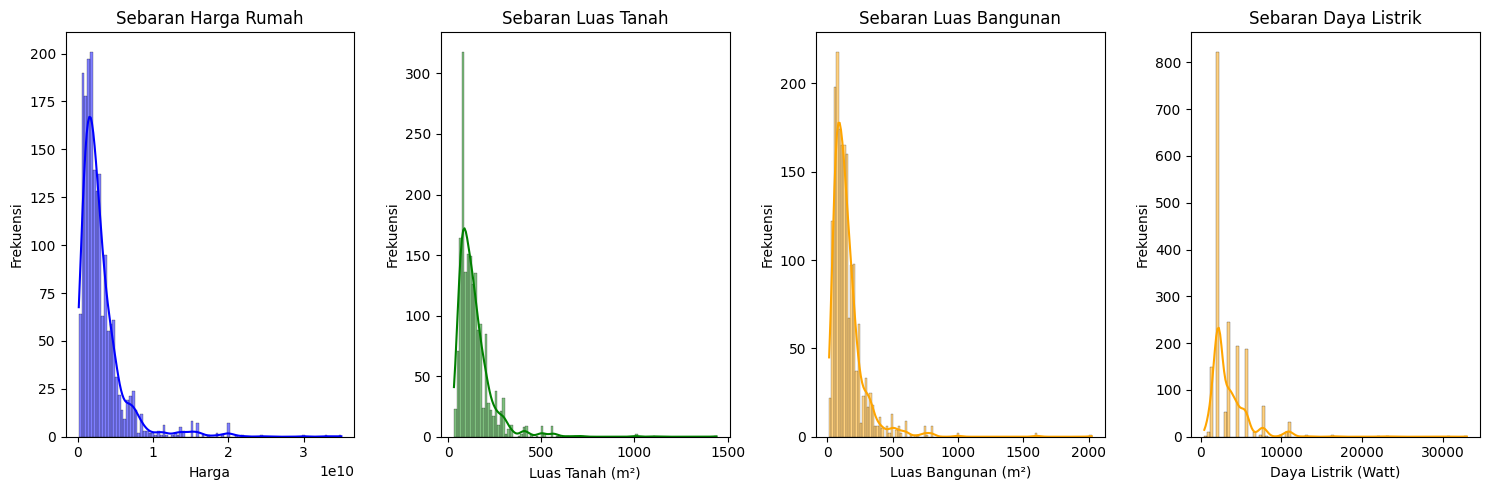

In [11]:
# Mengatur ukuran plot
plt.figure(figsize=(15, 5))

# Plot untuk harga
plt.subplot(1, 4, 1)  # 1 baris, 3 kolom, subplot ke-1
sns.histplot(df_kabupaten['Harga'], kde=True, color='blue')
plt.title('Sebaran Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

# Plot untuk luas tanah
plt.subplot(1, 4, 2)  # 1 baris, 3 kolom, subplot ke-2
sns.histplot(df_kabupaten['Luas Tanah'], kde=True, color='green')
plt.title('Sebaran Luas Tanah')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 4, 3)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Luas Bangunan'], kde=True, color='orange')
plt.title('Sebaran Luas Bangunan')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 4, 4)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Daya Listrik'], kde=True, color='orange')
plt.title('Sebaran Daya Listrik')
plt.xlabel('Daya Listrik (Watt)')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [12]:
# Lihat skewness
print("Skewness distribusi kolom Harga: ", np.round(df_kabupaten['Harga'].skew(), 2))
print("Skewness distribusi kolom Luas Tanah: ", np.round(df_kabupaten['Luas Tanah'].skew(), 2))
print("Skewness distribusi kolom Luas Bangunan: ", np.round(df_kabupaten['Luas Bangunan'].skew(), 2))
print("Skewness distribusi kolom Daya Listrik: ", np.round(df_kabupaten['Daya Listrik'].skew(), 2))

Skewness distribusi kolom Harga:  3.83
Skewness distribusi kolom Luas Tanah:  4.06
Skewness distribusi kolom Luas Bangunan:  4.62
Skewness distribusi kolom Daya Listrik:  3.93


Kalau dilihat, datanya memiliki skewness positif sehingga perlu dilakukan normalisasi dengan log transfromation.

### Preparation
Data Pre-processing:
1. Log transformation
2. Ordinal Encoding
3. Feature selection

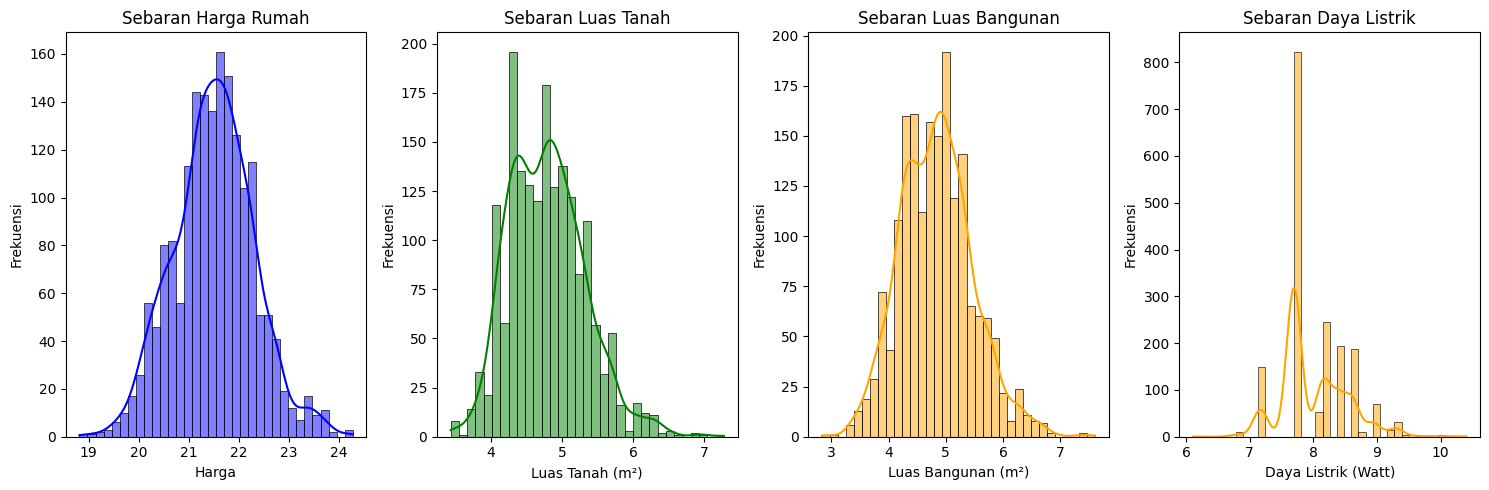

In [13]:
# Melakukan log transformation pada kolom 'Harga', 'Luas Tanah', 'Luas Bangunan', dan 'Daya Listrik'
df_kabupaten['Harga'] = np.log1p(df_kabupaten['Harga'])
df_kabupaten['Luas Tanah'] = np.log1p(df_kabupaten['Luas Tanah'])
df_kabupaten['Luas Bangunan'] = np.log1p(df_kabupaten['Luas Bangunan'])
df_kabupaten['Daya Listrik'] = np.log1p(df_kabupaten['Daya Listrik'])

# Menampilkan distribusi harga setelah transformasi
# Mengatur ukuran plot
plt.figure(figsize=(15, 5))

# Plot untuk harga
plt.subplot(1, 4, 1)  # 1 baris, 3 kolom, subplot ke-1
sns.histplot(df_kabupaten['Harga'], kde=True, color='blue')
plt.title('Sebaran Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

# Plot untuk luas tanah
plt.subplot(1, 4, 2)  # 1 baris, 3 kolom, subplot ke-2
sns.histplot(df_kabupaten['Luas Tanah'], kde=True, color='green')
plt.title('Sebaran Luas Tanah')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 4, 3)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Luas Bangunan'], kde=True, color='orange')
plt.title('Sebaran Luas Bangunan')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 4, 4)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Daya Listrik'], kde=True, color='orange')
plt.title('Sebaran Daya Listrik')
plt.xlabel('Daya Listrik (Watt)')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

Distribusinya sudah 'normal'

In [14]:
# Encoding
ordinal_enc = OrdinalEncoder(categories=[
    ['PPJB', 'HGB', 'Lainnya', 'SHM'],  # Urutan Sertifikat (PPJB rendah, SHM tertinggi)
    ['Butuh Renovasi', 'Bagus', 'Baru']  # Urutan Kondisi Properti
])

df_kabupaten[['Sertifikat', 'Kondisi Properti']] = ordinal_enc.fit_transform(df_kabupaten[['Sertifikat', 'Kondisi Properti']])

# Encoding Kecamatan
df_kabupaten = pd.get_dummies(df_kabupaten, columns=['Kecamatan'], prefix='kec')

# Lihat hasilnya
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1802 entries, 6 to 4990
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Harga                 1802 non-null   float64
 1   Kamar Tidur           1802 non-null   Int64  
 2   Kamar Mandi           1802 non-null   Int64  
 3   Luas Tanah            1802 non-null   Float64
 4   Luas Bangunan         1802 non-null   Float64
 5   Sertifikat            1802 non-null   float64
 6   Daya Listrik          1802 non-null   Float64
 7   Jumlah Lantai         1802 non-null   Int64  
 8   Kondisi Properti      1802 non-null   float64
 9   Carport               1802 non-null   Int64  
 10  Kamar Tidur Pembantu  1802 non-null   Int64  
 11  Kamar Mandi Pembantu  1802 non-null   Int64  
 12  kec_Balaraja          1802 non-null   bool   
 13  kec_Cikupa            1802 non-null   bool   
 14  kec_Cisauk            1802 non-null   bool   
 15  kec_Curug             1802

In [15]:
# Lihat 5 data teratas setelah encoding
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,...,kec_Mauk,kec_Pagedangan,kec_Panongan,kec_Pasar Kemis,kec_Rajeg,kec_Sepatan,kec_Sindang Jaya,kec_Solear,kec_Teluk Naga,kec_Tigaraksa
6,20.723266,2,1,4.51086,4.025352,3.0,7.696667,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
8,20.723266,2,1,4.51086,4.025352,3.0,7.696667,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
14,20.723266,3,2,6.46925,4.912655,3.0,7.170888,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
15,20.723266,3,2,4.204693,4.382027,3.0,8.160804,2,1.0,1,...,False,False,False,True,False,False,False,False,False,False
21,20.723266,3,3,4.795791,5.117994,3.0,7.170888,2,2.0,2,...,False,False,False,False,False,False,False,False,False,False


Feature Selection

<Axes: >

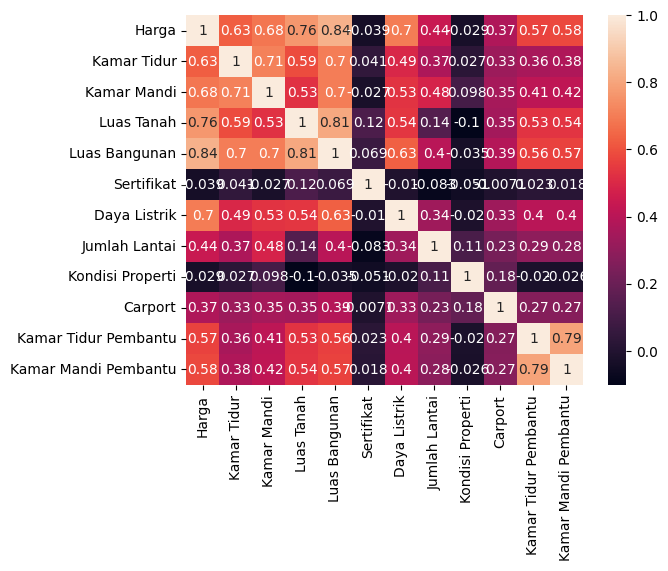

In [16]:
# Lihat korelasi antar variabel numerik (Pearson)
sns.heatmap(df_kabupaten.select_dtypes(include=['number']).corr(), annot=True)

In [17]:
# Pisahkan fitur dan target
X = df_kabupaten.drop(columns=['Harga', 'Sertifikat', 'Kondisi Properti'], axis=1)
y = df_kabupaten['Harga']

# Split dataset menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling & Evaluation
---
Base Model Linear Regression

In [18]:
# Inisialisasi model Linear Regression
lr = LinearRegression()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    lr.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = lr.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross validation score on base Multiple Linear Regression:")
print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
lr.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_lr_train = lr.predict(X_train)

# Menghitung metrik pada data uji
train_r2_base_lr = r2_score(y_train, y_pred_lr_train)
train_rmse_base_lr = root_mean_squared_error(y_train, y_pred_lr_train)
train_mape_base_lr = mean_absolute_percentage_error(y_train, y_pred_lr_train)

# Melakukan prediksi pada data uji
y_pred_lr = lr.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_lr = r2_score(y_test, y_pred_lr)
test_rmse_base_lr = root_mean_squared_error(y_test, y_pred_lr)
test_mape_base_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("\nMultiple Linear Regression Result:")
print(f"Train R²: {train_r2_base_lr}")
print(f"Train RMSE: {train_rmse_base_lr}")
print(f"Train MAPE: {train_mape_base_lr}\n")
print(f"Test R²: {test_r2_base_lr}")
print(f"Test RMSE: {test_rmse_base_lr}")
print(f"Test MAPE: {test_mape_base_lr}")

Cross validation score on base Multiple Linear Regression:
Mean CV R²: 0.8759147948991302
Mean CV RMSE: 0.2799354170526741
Mean CV MAPE: 0.009958754410688784

Multiple Linear Regression Result:
Train R²: 0.8843862031543059
Train RMSE: 0.27132351353432665
Train MAPE: 0.009629559827976992

Test R²: 0.8911196565776307
Test RMSE: 0.2696847037955193
Test MAPE: 0.00949586836795946


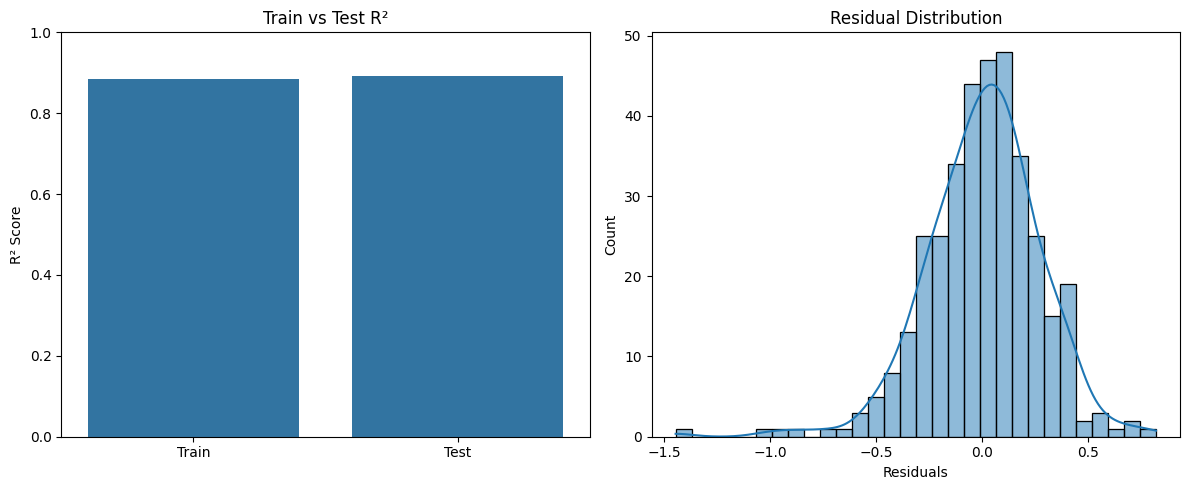

In [19]:
# Hitung R² pada training data
train_r2 = r2_score(y_train, lr.predict(X_train))

# Buat figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train vs Test R² Comparison
sns.barplot(x=["Train", "Test"], y=[train_r2, test_r2_base_lr], ax=axes[0])
axes[0].set_title("Train vs Test R²")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("R² Score")

# Residual Plot
residuals = y_test - y_pred_lr
sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

Base Model Random Forest

In [20]:
# Inisialisasi model Linear Regression
rfr = RandomForestRegressor()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    rfr.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = rfr.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross validation score on base Random Forest:")
print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
rfr.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_rf_train = rfr.predict(X_train)

# Menghitung metrik pada data latih
train_r2_base_rfr = r2_score(y_train, y_pred_rf_train)
train_rmse_base_rfr = root_mean_squared_error(y_train, y_pred_rf_train)
train_mape_base_rfr = mean_absolute_percentage_error(y_train, y_pred_rf_train)

# Melakukan prediksi pada data uji
y_pred_rf = rfr.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_rfr = r2_score(y_test, y_pred_rf)
test_rmse_base_rfr = root_mean_squared_error(y_test, y_pred_rf)
test_mape_base_rfr = mean_absolute_percentage_error(y_test, y_pred_rf)

print("\nBase Random Forest Result:")
print(f"Train R²: {train_r2_base_rfr}")
print(f"Train RMSE: {train_rmse_base_rfr}")
print(f"Train MAPE: {train_mape_base_rfr}\n")
print(f"Test R²: {test_r2_base_rfr}")
print(f"Test RMSE: {test_rmse_base_rfr}")
print(f"Test MAPE: {test_mape_base_rfr}")

Cross validation score on base Random Forest:
Mean CV R²: 0.8957225527426156
Mean CV RMSE: 0.2567589768137045
Mean CV MAPE: 0.008285867245233

Base Random Forest Result:
Train R²: 0.985854775744277
Train RMSE: 0.09490465590889723
Train MAPE: 0.003029235553935582

Test R²: 0.9123278482234574
Test RMSE: 0.24199835082149357
Test MAPE: 0.007399435630163423


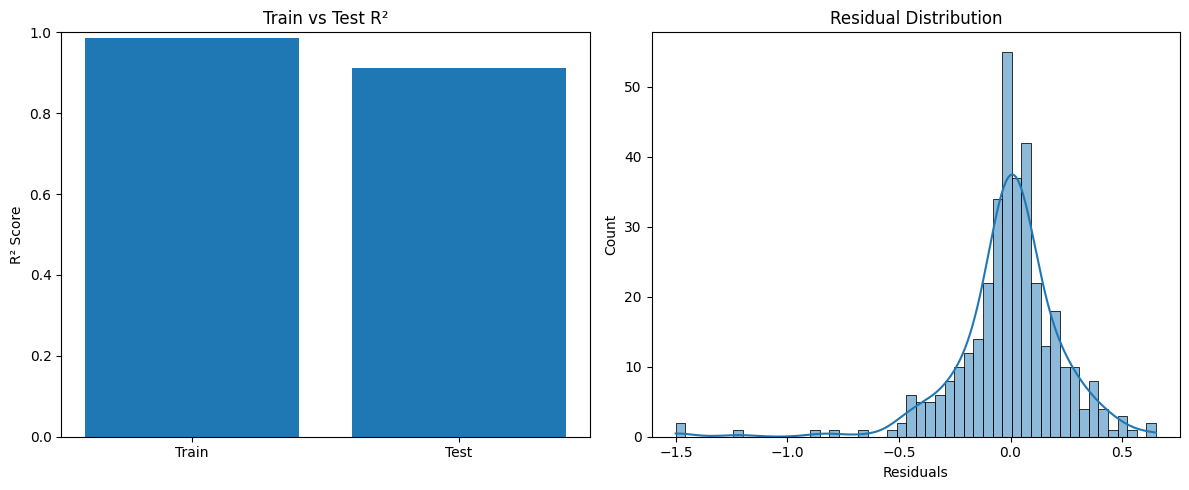

In [21]:
# Mendapatkan skor R² untuk data train
train_r2_rf = r2_score(y_train, rfr.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_rf, test_r2_base_rfr])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_rf = y_test - y_pred_rf

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

Base Model XGBoost

In [22]:
# Inisialisasi model Linear Regression
xgb = XGBRegressor()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan metrik
r2_scores = []
rmse_scores = []
mape_scores = []

# Melakukan K-Fold Cross-Validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Melatih model
    xgb.fit(X_train_fold, y_train_fold)
    
    # Melakukan prediksi
    y_val_pred = xgb.predict(X_val_fold)
    
    # Menghitung metrik
    r2 = r2_score(y_val_fold, y_val_pred)
    rmse = root_mean_squared_error(y_val_fold, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    
    # Menyimpan metrik
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross validation score on base XGBoost:")
print(f"Mean CV R²: {mean_r2}")
print(f"Mean CV RMSE: {mean_rmse}")
print(f"Mean CV MAPE: {mean_mape}")

# Melatih model pada seluruh data pelatihan
xgb.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_xgb_train = xgb.predict(X_train)

# Menghitung metrik pada data latih
train_r2_base_xgb = r2_score(y_train, y_pred_xgb_train)
train_rmse_base_xgb = root_mean_squared_error(y_train, y_pred_xgb_train)
train_mape_base_xgb = mean_absolute_percentage_error(y_train, y_pred_xgb_train)

# Melakukan prediksi pada data uji
y_pred_xgb = xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_xgb = r2_score(y_test, y_pred_xgb)
test_rmse_base_xgb = root_mean_squared_error(y_test, y_pred_xgb)
test_mape_base_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("\nBase XGBoost Result:")
print(f"Train R²: {train_r2_base_xgb}")
print(f"Train RMSE: {train_rmse_base_xgb}")
print(f"Train MAPE: {train_mape_base_xgb}\n")
print(f"Test R²: {test_r2_base_xgb}")
print(f"Test RMSE: {test_rmse_base_xgb}")
print(f"Test MAPE: {test_mape_base_xgb}")

Cross validation score on base XGBoost:
Mean CV R²: 0.8975743743755717
Mean CV RMSE: 0.2537300069491567
Mean CV MAPE: 0.008380986646016228

Base XGBoost Result:
Train R²: 0.9909456721485125
Train RMSE: 0.07592952943068079
Train MAPE: 0.0024836703735919975

Test R²: 0.9171015128981692
Test RMSE: 0.23531785220330176
Test MAPE: 0.007205804408905651


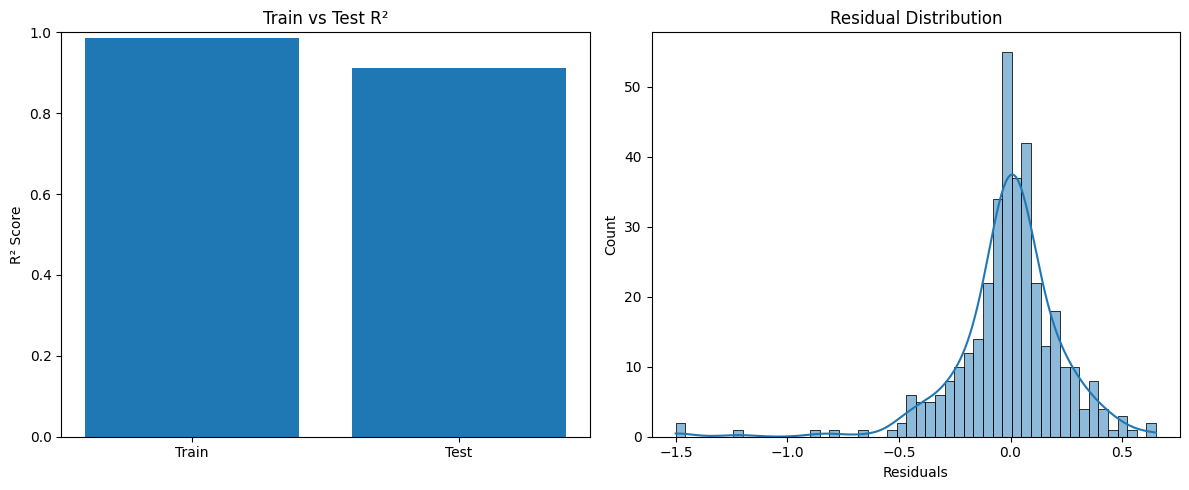

In [23]:
# Mendapatkan skor R² untuk data train
train_r2_xgb = r2_score(y_train, xgb.predict(X_train))

# Plot Train vs Test R²
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(["Train", "Test"], [train_r2_rf, test_r2_base_rfr])
plt.ylim(0, 1)
plt.ylabel("R² Score")
plt.title("Train vs Test R²")

# Menghitung residuals
y_residuals_xgb = y_test - y_pred_xgb

# Plot Residual Distribution
plt.subplot(1, 2, 2)
sns.histplot(y_residuals_rf, kde=True, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

Random Forest dengan Optuna

In [24]:
# Fungsi Optuna untuk tuning Random Forest
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1300, 1800, step=100),  # Tambah jumlah pohon
        "max_depth": trial.suggest_int("max_depth", 50, 100, step=10),  # Kedalaman optimal
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # Tetap fleksibel
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),  # Kembalikan ke range lebih optimal
        "max_features": trial.suggest_float("max_features", 0.6, 0.9),  # Kembalikan agar menangkap lebih banyak informasi
        "bootstrap": True,  # Gunakan Bootstrap
        "max_samples": trial.suggest_float("max_samples", 0.85, 0.95)
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

    # Gunakan 5-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2", n_jobs=-1)

    return np.mean(scores)  # Ambil rata-rata R² sebagai metric utama

# Jalankan Optuna
study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective, n_trials=100)

# Print hasil tuning terbaik
print("Best hyperparameters for Random Forest:", study_rf.best_params)

# Latih model final dengan hyperparameter terbaik
best_params_rf = study_rf.best_params
final_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)

# Evaluasi model di data latih
y_pred_opt_rf_train = final_rf.predict(X_train)
train_rmse_opt_rfr = root_mean_squared_error(y_train, y_pred_opt_rf_train)
train_r2_opt_rfr = r2_score(y_train, y_pred_opt_rf_train)
train_mape_opt_rfr = mean_absolute_percentage_error(y_train, y_pred_opt_rf_train)

# Evaluasi model di data uji
y_pred_opt_rf = final_rf.predict(X_test)
test_rmse_opt_rfr = root_mean_squared_error(y_test, y_pred_opt_rf)
test_r2_opt_rfr = r2_score(y_test, y_pred_opt_rf)
test_mape_opt_rfr = mean_absolute_percentage_error(y_test, y_pred_opt_rf)

print("\nRandom Forest Optuna Result:")
print(f"Train R²: {train_r2_opt_rfr}")
print(f"Train RMSE: {train_rmse_opt_rfr}")
print(f"Train MAPE: {train_mape_opt_rfr}\n")
print(f"Test R²: {test_r2_opt_rfr}")
print(f"Test RMSE: {test_rmse_opt_rfr}")
print(f"Test MAPE: {test_mape_opt_rfr}")

[I 2025-02-24 13:24:16,045] A new study created in memory with name: no-name-08cdc689-f8c7-4848-aaf1-deb10fab7665
[I 2025-02-24 13:24:22,270] Trial 0 finished with value: 0.8798585615812801 and parameters: {'n_estimators': 1500, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.6992237680480465, 'max_samples': 0.9260206573033306}. Best is trial 0 with value: 0.8798585615812801.
[I 2025-02-24 13:24:28,450] Trial 1 finished with value: 0.8826561987880595 and parameters: {'n_estimators': 1800, 'max_depth': 80, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.8567323205026436, 'max_samples': 0.9363893210057833}. Best is trial 0 with value: 0.8798585615812801.
[I 2025-02-24 13:24:34,025] Trial 2 finished with value: 0.8937423831556517 and parameters: {'n_estimators': 1600, 'max_depth': 70, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.8148725190200312, 'max_samples': 0.8978445419136378}. Best is trial 0 with value: 0.8798585

Best hyperparameters for Random Forest: {'n_estimators': 1500, 'max_depth': 60, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.8682099096969069, 'max_samples': 0.8537216397135386}

Random Forest Optuna Result:
Train R²: 0.9291625175396003
Train RMSE: 0.21238026552786604
Train MAPE: 0.007098004675010867

Test R²: 0.9011024260892901
Test RMSE: 0.2570244227335685
Test MAPE: 0.008546418708513939


XGBoost dengan Optuna

In [25]:
# Definisikan fungsi tujuan untuk Optuna
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1200, 2500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.85, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        "gamma": trial.suggest_float("gamma", 0.1, 3),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 5)
    }

    # Inisialisasi model XGBoost
    model = XGBRegressor(**params)

    # Inisialisasi KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Menyimpan metrik
    r2_scores = []
    mape_scores = []
    
    # Melakukan K-Fold Cross-Validation
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Melatih model
        model.fit(X_train_fold, y_train_fold)
        
        # Melakukan prediksi
        y_val_pred = model.predict(X_val_fold)
        
        # Menghitung R²
        r2 = r2_score(y_val_fold, y_val_pred)
        r2_scores.append(r2)
        
        # Menghitung MAPE
        mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
        mape_scores.append(mape)

    # Mengembalikan rata-rata R² sebagai nilai yang akan dioptimalkan
    return np.mean(r2_scores)

# Tuning hyperparameter dengan Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=100)

# Menampilkan hyperparameter terbaik
print("Best hyperparameters: ", study_xgb.best_params)

# Melatih model dengan hyperparameter terbaik
best_params = study_xgb.best_params
best_model_xgb = XGBRegressor(**best_params)
best_model_xgb.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_opt_xgb_train = best_model_xgb.predict(X_train)

# Menghitung metrik pada data uji
train_r2_opt_xgb = r2_score(y_train, y_pred_opt_xgb_train)
train_rmse_opt_xgb = root_mean_squared_error(y_train, y_pred_opt_xgb_train)
train_mape_opt_xgb = mean_absolute_percentage_error(y_train, y_pred_opt_xgb_train)

# Melakukan prediksi pada data uji
y_pred_opt_xgb = best_model_xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_opt_xgb = r2_score(y_test, y_pred_opt_xgb)
test_rmse_opt_xgb = root_mean_squared_error(y_test, y_pred_opt_xgb)
test_mape_opt_xgb = mean_absolute_percentage_error(y_test, y_pred_opt_xgb)

print("\nXGBoost Optuna Result:")
print(f"Train R²: {train_r2_opt_xgb}")
print(f"Train RMSE: {train_rmse_opt_xgb}")
print(f"Train MAPE: {train_mape_opt_xgb}\n")
print(f"Test R²: {test_r2_opt_xgb}")
print(f"Test RMSE: {test_rmse_opt_xgb}")
print(f"Test MAPE: {test_mape_opt_xgb}")

[I 2025-02-24 13:29:53,524] A new study created in memory with name: no-name-b4322337-5059-42ce-a2a6-776451fb5f83


[I 2025-02-24 13:29:55,697] Trial 0 finished with value: 0.8795884190050469 and parameters: {'n_estimators': 1500, 'learning_rate': 0.011361341691971482, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9894676633114756, 'colsample_bytree': 0.849138231335268, 'gamma': 0.9594646755049818, 'reg_alpha': 1.1584499669496306, 'reg_lambda': 3.3517626377340934}. Best is trial 0 with value: 0.8795884190050469.
[I 2025-02-24 13:29:57,733] Trial 1 finished with value: 0.8806970904196483 and parameters: {'n_estimators': 1400, 'learning_rate': 0.015169946559582405, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8803281100364825, 'colsample_bytree': 0.9047267561768813, 'gamma': 1.0331681561511397, 'reg_alpha': 1.5027888294825176, 'reg_lambda': 1.148406513096695}. Best is trial 1 with value: 0.8806970904196483.
[I 2025-02-24 13:30:00,688] Trial 2 finished with value: 0.8641148624665899 and parameters: {'n_estimators': 2200, 'learning_rate': 0.01071063773569549, 'max_depth': 4, 'min_child_

Best hyperparameters:  {'n_estimators': 2300, 'learning_rate': 0.023020189922551483, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8700613049332782, 'colsample_bytree': 0.928692682549585, 'gamma': 0.10325995534489044, 'reg_alpha': 1.1357731688120616, 'reg_lambda': 2.1283028805590045}

XGBoost Optuna Result:
Train R²: 0.9363112760187636
Train RMSE: 0.20137885827187627
Train MAPE: 0.007094378706240056

Test R²: 0.9105986511249463
Test RMSE: 0.24437321875969453
Test MAPE: 0.008196893997942099


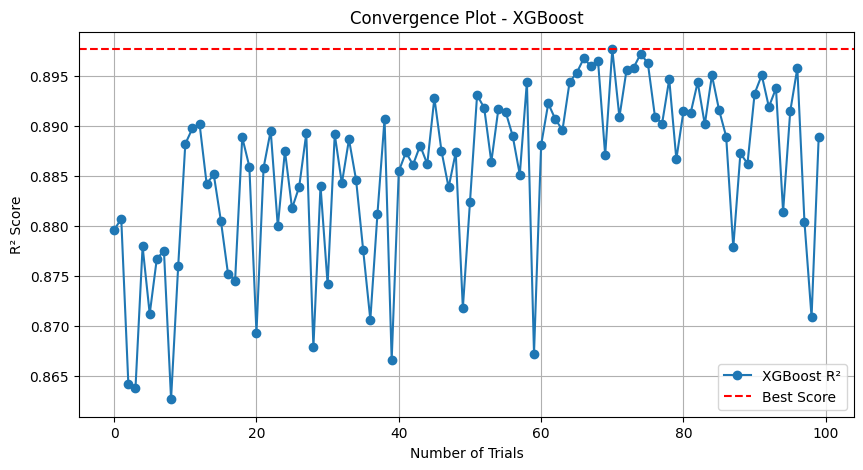

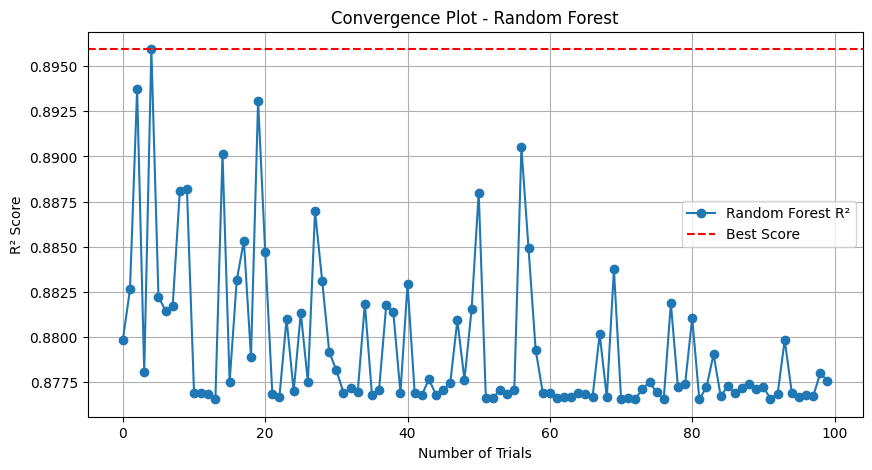

In [26]:
# Fungsi untuk menampilkan convergence plot
def plot_convergence(study, model_name):
    trials = study.trials_dataframe()
    
    plt.figure(figsize=(10, 5))
    plt.plot(trials["number"], trials["value"], marker="o", linestyle="-", label=f"{model_name} R²")
    plt.axhline(y=max(trials["value"]), color="r", linestyle="--", label="Best Score")
    
    plt.xlabel("Number of Trials")
    plt.ylabel("R² Score")
    plt.title(f"Convergence Plot - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Menampilkan plot untuk XGBoost dan Random Forest
plot_convergence(study_xgb, "XGBoost")
plot_convergence(study_rf, "Random Forest")

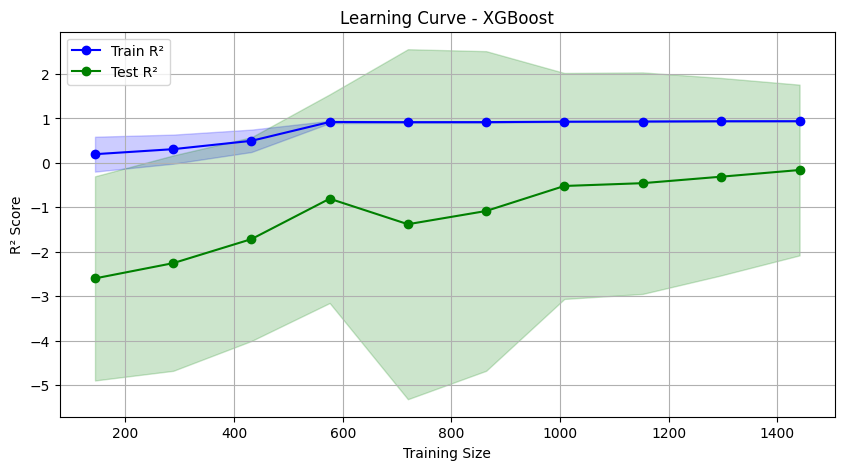

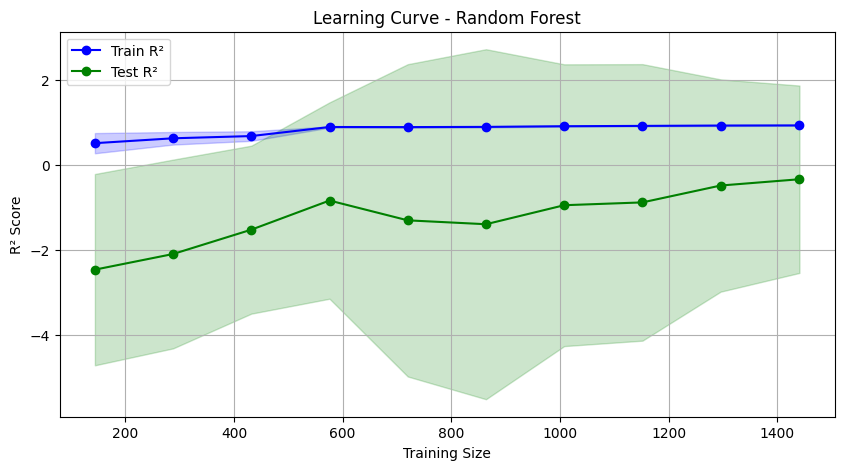

In [27]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name):
    """Plot Learning Curve (Train vs Test)"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="r2", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_mean, label="Train R²", marker="o", color="blue")
    plt.plot(train_sizes, test_mean, label="Test R²", marker="o", color="green")
    
    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), 
                     train_mean + np.std(train_scores, axis=1), color="blue", alpha=0.2)
    plt.fill_between(train_sizes, test_mean - np.std(test_scores, axis=1), 
                     test_mean + np.std(test_scores, axis=1), color="green", alpha=0.2)
    
    plt.xlabel("Training Size")
    plt.ylabel("R² Score")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Gunakan model terbaik dari Optuna
best_xgb = XGBRegressor(**study_xgb.best_params, random_state=42)
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)

# Plot Learning Curve
plot_learning_curve(best_xgb, X, y, "XGBoost")
plot_learning_curve(best_rf, X, y, "Random Forest")


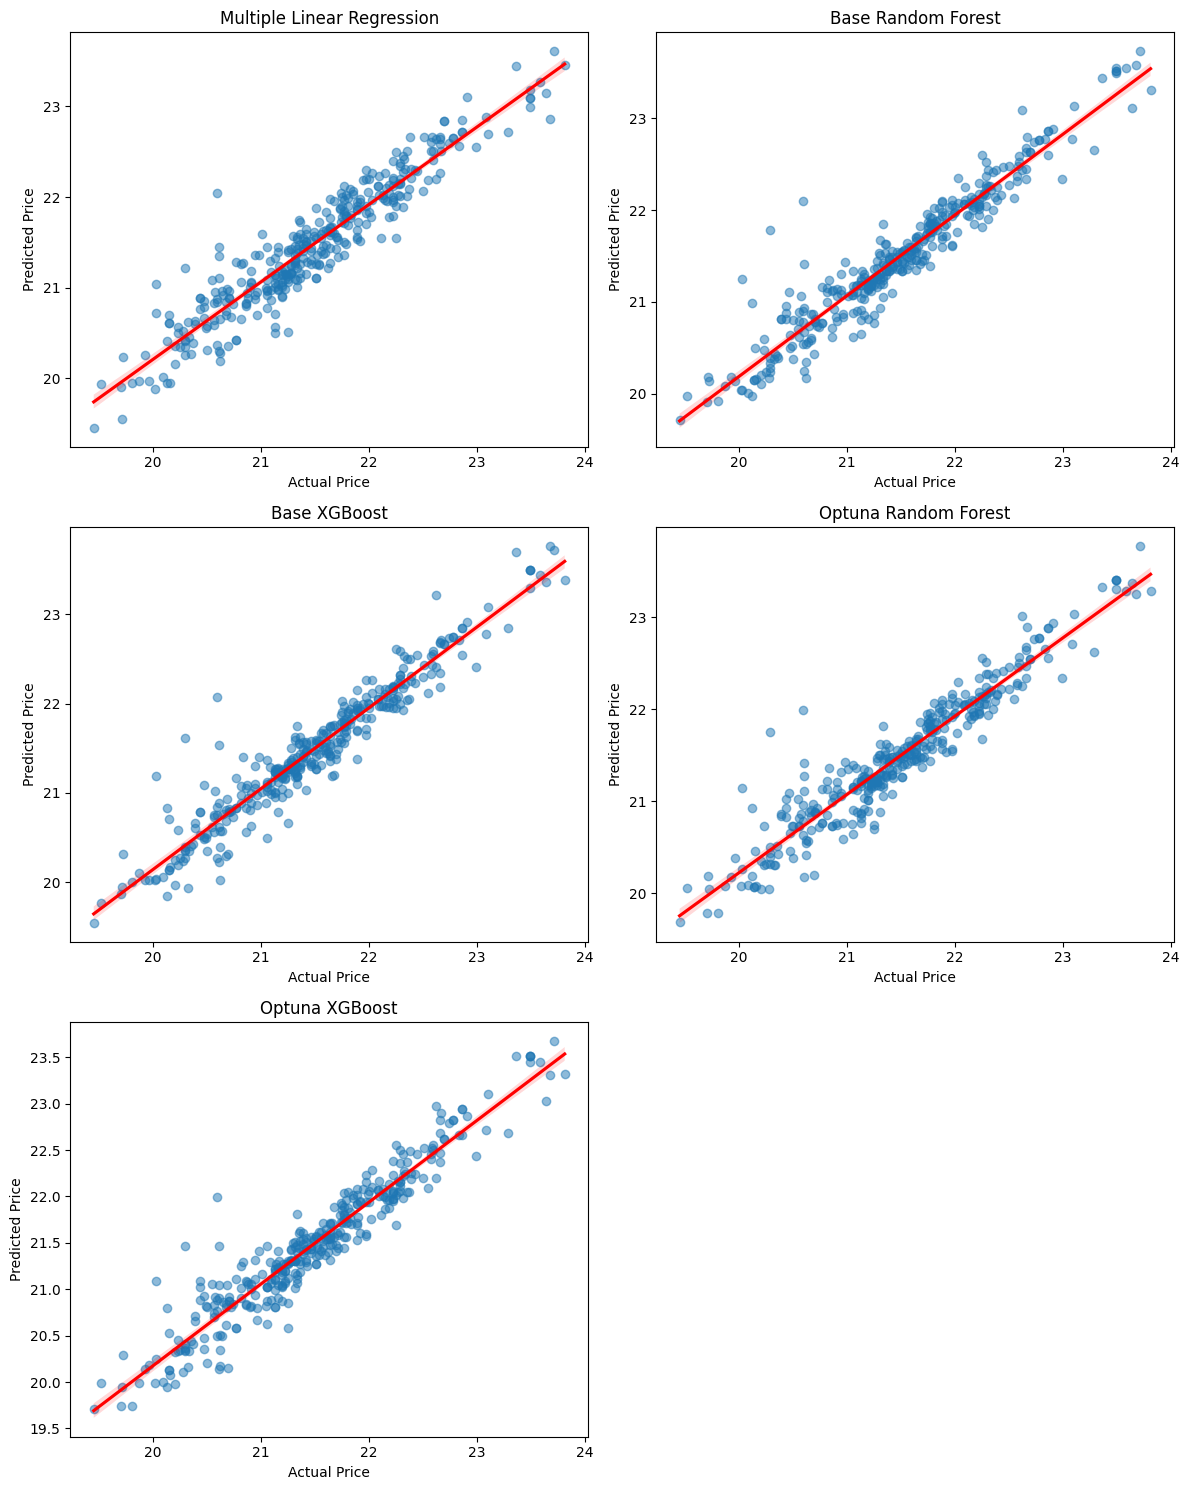

In [28]:
# Buat figure dan axis untuk 3x2 grid (karena ada 5 model, satu slot akan kosong)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot untuk Multiple Linear Regression
sns.regplot(x=y_test, y=y_pred_lr, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[0, 0])
axes[0, 0].set_title('Multiple Linear Regression')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')

# Plot untuk Base Random Forest
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title('Base Random Forest')
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')

# Plot untuk Base XGBoost
sns.regplot(x=y_test, y=y_pred_xgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[1, 0])
axes[1, 0].set_title('Base XGBoost')
axes[1, 0].set_xlabel('Actual Price')
axes[1, 0].set_ylabel('Predicted Price')

# Plot untuk Optuna Random Forest
sns.regplot(x=y_test, y=y_pred_opt_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[1, 1])
axes[1, 1].set_title('Optuna Random Forest')
axes[1, 1].set_xlabel('Actual Price')
axes[1, 1].set_ylabel('Predicted Price')

# Plot untuk Optuna XGBoost
sns.regplot(x=y_test, y=y_pred_opt_xgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[2, 0])
axes[2, 0].set_title('Optuna XGBoost')
axes[2, 0].set_xlabel('Actual Price')
axes[2, 0].set_ylabel('Predicted Price')

# Hapus subplot kosong (axes[2,1])
fig.delaxes(axes[2, 1])

# Atur layout agar tidak bertabrakan
plt.tight_layout()
plt.show()


Evaluasi Keseluruhan

In [29]:
df_eval_test = pd.DataFrame(data={
    'Model' : ['Multiple Linear Regression', 'Base Random Forest', 'Base XGBoost', 'Optuna Random Forest', 'Optuna XGBoost'],
    'R-squared' : [test_r2_base_lr, test_r2_base_rfr, test_r2_base_xgb, test_r2_opt_rfr, test_r2_opt_xgb],
    'RMSE' : [test_rmse_base_lr, test_rmse_base_rfr, test_rmse_base_xgb, test_rmse_opt_rfr, test_rmse_opt_xgb],
    'MAPE' : [test_mape_base_lr, test_mape_base_rfr, test_mape_base_xgb, test_mape_opt_rfr, test_mape_opt_xgb]
})

df_eval_train = pd.DataFrame(data={
    'Model' : ['Multiple Linear Regression', 'Base Random Forest', 'Base XGBoost', 'Optuna Random Forest', 'Optuna XGBoost'],
    'R-squared' : [train_r2_base_lr, train_r2_base_rfr, train_r2_base_xgb, train_r2_opt_rfr, train_r2_opt_xgb],
    'RMSE' : [train_rmse_base_lr, train_rmse_base_rfr, train_rmse_base_xgb, train_rmse_opt_rfr, train_rmse_opt_xgb],
    'MAPE' : [train_mape_base_lr, train_mape_base_rfr, train_mape_base_xgb, train_mape_opt_rfr, train_mape_opt_xgb]
})

print("Perbandingan akurasi di train set:\n")
df_eval_train

Perbandingan akurasi di train set:



,Model,R-squared,RMSE,MAPE
0,Multiple Linear Regression,0.884386,0.271324,0.009630
1,Base Random Forest,0.985855,0.094905,0.003029
2,Base XGBoost,0.990946,0.075930,0.002484
3,Optuna Random Forest,0.929163,0.212380,0.007098
4,Optuna XGBoost,0.936311,0.201379,0.007094


In [30]:
print("Perbandingan akurasi di test set:\n")
df_eval_test

Perbandingan akurasi di test set:



,Model,R-squared,RMSE,MAPE
0,Multiple Linear Regression,0.891120,0.269685,0.009496
1,Base Random Forest,0.912328,0.241998,0.007399
2,Base XGBoost,0.917102,0.235318,0.007206
3,Optuna Random Forest,0.901102,0.257024,0.008546
4,Optuna XGBoost,0.910599,0.244373,0.008197


In [ ]:
import pkgutil
import importlib
import sys
import subprocess

# Mendapatkan daftar library yang diimport dalam notebook
imported_modules = {name for _, name, _ in pkgutil.iter_modules() if importlib.util.find_spec(name)}

# Mengambil daftar package yang terinstal beserta versinya
from importlib.metadata import distributions  # Untuk Python 3.8+
installed_packages = {dist.metadata["Name"].lower(): dist.metadata["Version"] for dist in distributions()}

# Menyaring hanya library yang diimpor dalam notebook
used_packages = {pkg: installed_packages[pkg] for pkg in imported_modules if pkg in installed_packages}

# Simpan ke file requirements.txt
with open("notebook_requirements.txt", "w") as f:
    for pkg, version in used_packages.items():
        f.write(f"{pkg}=={version}\n")

print("requirements.txt telah dibuat.")

requirements.txt telah dibuat.


In [32]:
# Export model dan encoder untuk persiapan deployment
import pickle

# Simpan model XGBoost Optuna
with open("../Model/xgboost_optuna.pkl", "wb") as f:
    pickle.dump(best_model_xgb, f)

# Simpan Ordinal Encoder
with open("../Model/ordinal_encoder.pkl", "wb") as f:
    pickle.dump(ordinal_enc, f)

print("Semua objek telah disimpan dalam file .pkl!")

Semua objek telah disimpan dalam file .pkl!
